In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot
import eelbrain
import mne
#import trftools

from pprint import pprint
import numpy as np

/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/eelbrain/mne_fixes/_interpolation.py:13: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_types, pick_channels
/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/eelbrain/mne_fixes/_interpolation.py:13: FutureWarning: mne.io.pick.pick_channels is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_types, pick_channels


In [3]:
## ESLs ##

#STIMULI = [str(i) for i in range(1, 13)]
DATA_ROOT = Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
#PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
#PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]  #S01_alice-raw.fif
# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TRF_DIR.mkdir(exist_ok=True)
print(ESL_SUBJECTS)
print(len(ESL_SUBJECTS))  # 26

DST = TRF_DIR / 'ESLs_figures'
DST.mkdir(exist_ok=True)

['n_2_S019_ICAed_raw.fif', 'n_2_S020_ICAed_raw.fif', 'n_2_S021_ICAed_raw.fif', 'n_2_S022_ICAed_raw.fif', 'n_2_S023_ICAed_raw.fif', 'n_2_S026_ICAed_raw.fif', 'n_2_S024_ICAed_raw.fif', 'n_2_S012_ICAed_raw.fif', 'n_2_S013_ICAed_raw.fif', 'n_2_S015_ICAed_raw.fif', 'n_2_S016_ICAed_raw.fif', 'n_2_S011_ICAed_raw.fif', 'n_2_S010_ICAed_raw.fif', 'n_2_S029_ICAed_raw.fif', 'n_2_S027_ICAed_raw.fif', 'n_2_S028_ICAed_raw.fif', 'n_2_S030_ICAed_raw.fif', 'n_2_S031_ICAed_raw.fif', 'n_2_S017_ICAed_raw.fif', 'n_2_S025_ICAed_raw.fif', 'n_2_S032_ICAed_raw.fif', 'n_2_S034_ICAed_raw.fif', 'n_2_S035_ICAed_raw.fif', 'n_2_S036_ICAed_raw.fif', 'n_2_S038_ICAed_raw.fif', 'n_2_S039_ICAed_raw.fif']
26


## ESLs Auditory TRFs

##### Pre-define models here to have easier access during estimation. In the future, additional models could be added here and the script re-run to generate additional TRFs.
    models = {
        # Acoustic models
        'envelope': [envelope],
        'envelope+onset': [envelope, onset_envelope],
        'acoustic': [gammatone, gammatone_onsets],
        
        # Models with word-onsets and word-class
        'words': [word_onsets],
        'words+lexical': [word_onsets, word_lexical, word_nlexical],
        'acoustic+words': [gammatone, gammatone_onsets, word_onsets],
        'acoustic+words+lexical': [gammatone, gammatone_onsets, word_onsets, word_lexical, word_nlexical],
        
        # Language Models
        'Ngram': [word_Ngram, word_onsets, word_lexical, word_nlexical],
        'CFG': [word_CFG, word_onsets, word_lexical, word_nlexical],
        'Ngram-CFG_all': [word_Ngram, word_CFG, word_onsets, word_lexical, word_nlexical]
    }

m = covar  
m1 = covar + Ngram  
m2 = covar + CFG  
m3 = covar + Ngram + CFG  

In [5]:
subj_sLIST = []
for subj_name in ESL_SUBJECTS:
    subj_sLIST.append(int(subj_name[5:8]))
print(subj_sLIST)

[19, 20, 21, 22, 23, 26, 24, 12, 13, 15, 16, 11, 10, 29, 27, 28, 30, 31, 17, 25, 32, 34, 35, 36, 38, 39]


In [10]:
### For ESLs  ###
#subj = 2
"""
subject_nSTR_p = "n_S%.3d_ICAed_raw.fif" %subj

raw = mne.io.read_raw_fif(EEG_DIR / f'{subject_nSTR_p}', preload=True)

montage_x = eelbrain.load.fiff.sensor_dim(raw.info)
#temp_data = eeg_.T *1e+6
eeg_concatenated = eelbrain.NDVar(temp_data, (time, montage_x), name='EEG', info={'unit': 'µV'})

SUBJECTS = ['1', '2', '3', '4', '5', '6', '7']
rows = []
for subject in SUBJECTS:
    trf = eelbrain.load.unpickle('Subj%s_TRFs_envelop_w_on.pickle'%(subject))
    rows.append([subject, trf.proportion_explained, trf.h[0].abs()])
    pass
data_env = eelbrain.Dataset.from_caselist(['subject', 'det', 'trf'], rows)
"""
#subj_sLIST = [3, 4, 5, 6, 7, 8]
subj_sLIST = []
for subj_name in ESL_SUBJECTS:
    subj_sLIST.append(int(subj_name[5:8]))
rowsLIST = []

# res.h[0] >> <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>

## TRFs Envelope  ##
for subj in  subj_sLIST:
    res = eelbrain.load.unpickle(TRF_DIR / Path('S%.3d/S%.3d envelope.pickle'%(subj, subj)))
    rowsLIST.append([subj, res.proportion_explained, res.h[0]])#.abs()])
data_env = eelbrain.Dataset.from_caselist(['subject', 'det', 'trf'], rowsLIST)
pprint(rowsLIST)
print(data_env)


#test that model predictive power on held-out data is > 0
test_envelope = eelbrain.testnd.TTestOneSample('det', ds=data_env, tail=1, pmin=0.05)
#p = eelbrain.plot.Topomap(test_envelope)
#cb = p.plot_colorbar(width=0.1)


# ## Envelope TRF
# Test the TRF with a one-sample *t*-test against 0. This tests the null-hypothesis that the electrical current direction at each time point was random across subjects. The systematic current directions shown below at anterior electrodes are typical of auditory responses. 

trf_envelope = eelbrain.testnd.TTestOneSample('trf', ds=data_env, pmin=0.05)
print(trf_envelope)  # print out the stats results
onesample_clus = trf_envelope.find_clusters(0.05)
print(onesample_clus) # print out the cluster result

# gammatone >> ,t=[0.87]
# gammatone_onset >> ,t=[0.42, 0.52]
p1 = eelbrain.plot.TopoArray(trf_envelope, t=[0.13, 0.35, 0.66, 0.99], clip='circle', cmap='xpolar', h=4, w = 8) #, t=[0.08, 0.16, 0.22, 0.45]
cb = p.plot_colorbar(width=0.1)

#p1.save(DST / 'ESLs_ALL26_Envelope TRF_envelop.png')

#x = trf的結果

[[19, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [20, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [21, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [22, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [23, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [26, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [24, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [12, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [13, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [15, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [16, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [11, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [10, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [29, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 

"\n#test that model predictive power on held-out data is > 0\ntest_envelope = eelbrain.testnd.TTestOneSample('det', ds=data_env, tail=1, pmin=0.05)\n#p = eelbrain.plot.Topomap(test_envelope)\n#cb = p.plot_colorbar(width=0.1)\n\n\n# ## Envelope TRF\n# Test the TRF with a one-sample *t*-test against 0. This tests the null-hypothesis that the electrical current direction at each time point was random across subjects. The systematic current directions shown below at anterior electrodes are typical of auditory responses. \n\ntrf_envelope = eelbrain.testnd.TTestOneSample('trf', ds=data_env, pmin=0.05)\nprint(trf_envelope)  # print out the stats results\nonesample_clus = trf_envelope.find_clusters(0.05)\nprint(onesample_clus) # print out the cluster result\n\n# gammatone >> ,t=[0.87]\n# gammatone_onset >> ,t=[0.42, 0.52]\np1 = eelbrain.plot.TopoArray(trf_envelope, t=[0.13, 0.35, 0.66, 0.99], clip='circle', cmap='xpolar', h=4, w = 8) #, t=[0.08, 0.16, 0.22, 0.45]\ncb = p.plot_colorbar(width=0.

In [16]:
## TRF: envelope+onset ##
#subj_sLIST = [3, 4, 5, 6, 7, 8]
rowsLIST = []

for subj in  subj_sLIST:
    res = eelbrain.load.unpickle(TRF_DIR / Path('S%.3d/S%.3d envelope+onset.pickle'%(subj, subj)))
    rowsLIST.append([subj, res.proportion_explained, *res.h])#.abs()])
    x_names = res.x
data_onset = eelbrain.Dataset.from_caselist(['subject', 'det', *x_names], rowsLIST)
pprint(rowsLIST)
print(data_onset)

test_onset = eelbrain.testnd.TTestOneSample('det', ds=data_onset, tail=1, pmin=0.05)
# Paired t-test by specifying two measurement NDVars with matched cases
# Note that this presupposes that subjects are in the same order
test_onset_envelope = eelbrain.testnd.TTestRelated(data_onset['det'], data_env['det'], tail=1, pmin=0.05)
p2 = eelbrain.plot.Topomap(
    [test_onset.masked_difference(), test_onset_envelope.masked_difference()], 
    axtitle=[['Envelope + Onsets\n', test_onset], ['Envelope + Onsets > Envelope\n', test_onset_envelope]],
    ncol=2, clip='circle')
cb = p.plot_colorbar(width=0.1)

p2.save(TRF_DIR / 'ESLs_ALL26_Envelope+onset-TRFs_topo.png')

o
o
o
o
o
o
o
o
o
o
o
o
o
o
o
o
o
o
o
o
o
o
o
o
o
o


"\ntest_onset = eelbrain.testnd.TTestOneSample('det', ds=data_onset, tail=1, pmin=0.05)\n# Paired t-test by specifying two measurement NDVars with matched cases\n# Note that this presupposes that subjects are in the same order\ntest_onset_envelope = eelbrain.testnd.TTestRelated(data_onset['det'], data_env['det'], tail=1, pmin=0.05)\np2 = eelbrain.plot.Topomap(\n    [test_onset.masked_difference(), test_onset_envelope.masked_difference()], \n    axtitle=[['Envelope + Onsets\n', test_onset], ['Envelope + Onsets > Envelope\n', test_onset_envelope]],\n    ncol=2, clip='circle')\ncb = p.plot_colorbar(width=0.1)\n\np2.save(TRF_DIR / 'ESLs_ALL26_Envelope+onset-TRFs_topo.png')\n"

[[19,
  <NDVar '1': 57 sensor>,
  <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
  <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>],
 [20,
  <NDVar '1': 57 sensor>,
  <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
  <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>],
 [21,
  <NDVar '1': 57 sensor>,
  <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
  <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>],
 [22,
  <NDVar '1': 57 sensor>,
  <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
  <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>],
 [23,
  <NDVar '1': 57 sensor>,
  <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
  <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>],
 [26,
  <NDVar '1': 57 sensor>,
  <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
  <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>],
 [24,
  <NDVar '1': 57 sensor>,
  <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
  <NDVar 'g

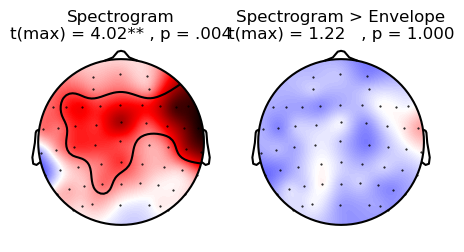

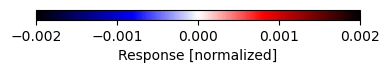

In [15]:
rowsLIST = []
x_names = None

for subj in  subj_sLIST:
    res = eelbrain.load.unpickle(TRF_DIR / Path('S%.3d/S%.3d acoustic.pickle'%(subj, subj)))
    rowsLIST.append([subj, res.proportion_explained, *res.h])#.abs()])
    x_names = res.x
data_acoustic = eelbrain.Dataset.from_caselist(['subject', 'det', *x_names], rowsLIST)
pprint(rowsLIST)
print(data_acoustic)

# Compare predictive power of the two models
test_acoustic = eelbrain.testnd.TTestOneSample('det', ds=data_acoustic, tail=1, pmin=0.05)
# Paired t-test by specifying two measurement NDVars with matched cases
# Note that this presupposes that subjects are in the same order
test_acoustic_onset = eelbrain.testnd.TTestRelated(data_acoustic['det'], data_onset['det'], tail=1, pmin=0.05)
p3 = eelbrain.plot.Topomap(
    [test_acoustic.masked_difference(), test_acoustic_onset.masked_difference()], 
    axtitle=[[['Spectrogram\n', test_acoustic], ], ['Spectrogram > Envelope\n', test_acoustic_onset]],
    ncol=2, clip='circle')
cb = p.plot_colorbar(width=0.1)

p3.save(TRF_DIR / 'ESLs_ALL26_acoustic-TRFs_topo.png')

AttributeError: 'numpy.float64' object has no attribute 'smooth'

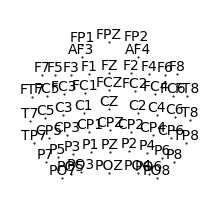

In [23]:
### LATER ANALYSIS  ###
# ## TRFs
# Since these spectrogram mTRFs have a frequency dimension in addition to time and sensor we have to slice or aggregate them for visualization on a 2d plot. We take two approaches: 
#
#  1) Sum across the frequency, based on the assumtopn that TRFs are similar for different frequency bands
#  2) Average across a group of neighboring sensors, to verify this assumtopn 

trf_spectrogram = eelbrain.testnd.TTestOneSample("gammatone.sum('frequency')", ds=data_acoustic, pmin=0.05)
trf_onset_spectrogram = eelbrain.testnd.TTestOneSample("gammatone_on.sum('frequency')", ds=data_acoustic, pmin=0.05)

#p4 = eelbrain.plot.TopoArray([trf_spectrogram, trf_onset_spectrogram], t=[0.050, 0.100, 0.150, 0.450], xlim=(-0.050, 0.950))

# Manually define sensors that are sensitive to acoustic responses 
#auditory_sensors = ['59', '20', '21', '7', '8', '9', '49', '19' ,'44', '45', '34' ,'35' ,'36' ,'10']
p5 = eelbrain.plot.SensorMap(data_acoustic['det'], h=2)

strf_spectrogram = data_acoustic['gammatone'].mean().smooth('frequency', window_samples=7, fix_edges=True)
strf_onset_spectrogram = data_acoustic['gammatone_on'].mean()

# the data type of data_acoustic['gammatone'].mean() = <class 'eelbrain._data_obj.NDVar'>

#p6 = eelbrain.plot.Array([strf_spectrogram, strf_onset_spectrogram], ncol=2, xlim=(-0.050, 0.950))

#p4.save(TRF_DIR / 'Natives_acoustic-TRFs_topo.png')
#p5.save(TRF_DIR / 'Natives_acoustic-TRFs_topo.png')
#p6.save(TRF_DIR / 'Natives_acoustic-TRFs_topo.png')

<TTestOneSample 'envelope', samples=10000, pmin=0.05, 29 clusters, p < .001>
id    n_sensors   tstart   tstop   duration   v         p        sig
--------------------------------------------------------------------
1     51          -0.12    0.46    0.58       3962.9    0        ***
260   43          0.57     1.02    0.45       -1621.2   0.0012   ** 
<TTestOneSample 'onset', samples=10000, pmin=0.05, 49 clusters, p < .001>
id   n_sensors   tstart   tstop   duration   v        p        sig
------------------------------------------------------------------
1    41          0.13     0.19    0.06       227.91   0.0185   *  
2    46          0.34     0.63    0.29       1810.7   0        ***


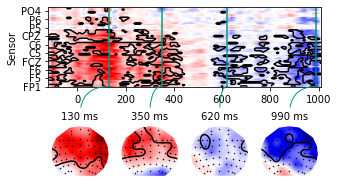

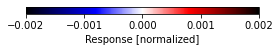

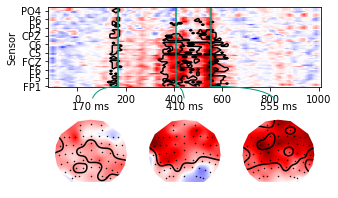

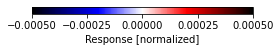

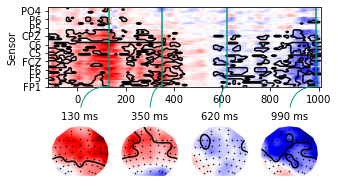

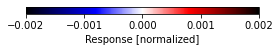

In [18]:
# Load cross-validated preditive power of all models
models = ['envelope', 'envelope+onset', 'acoustic']
rowsLIST = []

for model in models:
    for subj in  subj_sLIST:
        res = eelbrain.load.unpickle(TRF_DIR / Path('S%.3d/S%.3d %s.pickle'%(subj, subj, model)))
        rowsLIST.append([subj, model, res.proportion_explained])
model_data = eelbrain.Dataset.from_caselist(['subject', 'model', 'det'], rowsLIST)
# For more interpretable numbers, express proportion explained in terms of the maximum explained variability by the full model
index = model_data['model'] == 'acoustic'
model_data['det'] *= 100 / model_data[index, 'det'].mean('case').max('sensor')

# Redo tests with adjusted predictive power 
test_envelope = eelbrain.testnd.TTestOneSample('det', sub="model == 'envelope'", ds=model_data, tail=1, pmin=0.05)
test_acoustic = eelbrain.testnd.TTestOneSample('det', sub="model == 'acoustic'", ds=model_data, tail=1, pmin=0.05)
test_onset_envelope = eelbrain.testnd.TTestRelated('det', 'model', 'envelope+onset', 'envelope', 'subject', ds=model_data, tail=1, pmin=0.05)
test_acoustic_onset = eelbrain.testnd.TTestRelated('det', 'model', 'acoustic', 'envelope+onset', 'subject', ds=model_data, tail=1, pmin=0.05)

# sig. timepoints
t_envelope = [0.130, 0.350, 0.620, 0.990] # pilot8 = [0.050, 0.150, 0.320, 0.400]
t_onset = [0.170, 0.410, 0.555]

# T-test on Env+Onset TRF's "Env" part
trf_eo_envelope = eelbrain.testnd.TTestOneSample('envelope', ds=data_onset, pmin=0.05)
print(trf_eo_envelope)  # print out the stats results
onesample_eoEnv_clus = trf_eo_envelope.find_clusters(0.05)
print(onesample_eoEnv_clus) # print out the cluster result

# T-test on Env+Onset TRF's "Onset" part
trf_eo_onset = eelbrain.testnd.TTestOneSample('onset', ds=data_onset, pmin=0.05)
print(trf_eo_onset)  # print out the stats results
onesample_eoOnset_clus = trf_eo_onset.find_clusters(0.05)
print(onesample_eoOnset_clus) # print out the cluster result

#'Envelope TRF'
p7 = eelbrain.plot.TopoArray(trf_envelope, t=t_envelope) 
p7.plot_colorbar(width=0.1) #below=axes[1], **cbar_args, ticks=0, label='TRF (a.u.)')

#'Onset TRF' in envelope+onset
p8 = eelbrain.plot.TopoArray(trf_eo_onset, t=t_onset)
p8.plot_colorbar(width=0.1)

# 'Envelope TRF' in envelope+onset
p9 = eelbrain.plot.TopoArray(trf_eo_envelope, t=t_envelope)
p9.plot_colorbar(width=0.1)


"""
# 'Onset STRF (sum across frequency)'
p10 = eelbrain.plot.TopoArray(trf_onset_spectrogram, t=t_onset)
p10.plot_colorbar(width=0.1)
# 'Envelope STRF (sum across frequency)'
p11 = eelbrain.plot.TopoArray(trf_spectrogram, t=t_envelope)
p11.plot_colorbar(width=0.1)
"""


p7.save(DST / 'ESLs_ALL26_Envelope TRF_envelop.png')
p8.save(DST / 'ESLs_ALL26_Envelope+onset TRF_Onset TRF.png')
p9.save(DST / 'ESLs_ALL26_Envelope+onset TRF_Envelope TRF.png')
#p10.save(TRF_DIR / 'ESLs_Onset TRF_sum-of-freq.png')
#p11.save(TRF_DIR / 'ESLs_Envelope TRF_sum-of-freq.png')

## LATER  ##

In [20]:
subj = 3
#res = eelbrain.load.unpickle(TRF_DIR / Path('S%.3d/S%.3d acoustic.pickle'%(subj, subj)))
res.h

(<NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
 <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>)

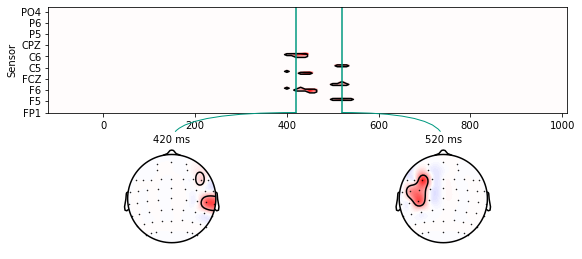

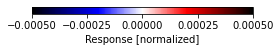

In [5]:
p = eelbrain.plot.TopoArray(trf_envelope,t=[0.42, 0.52], clip='circle', cmap='xpolar', h=4, w=8) #, t=[0.08, 0.16, 0.22, 0.45]
cb = p.plot_colorbar(width=0.1)

<NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>


ValueError: y=<NDVar 'gammatone': 57 sensor, 8 frequency, 114 time> is ambiguous for required dimensions ('sensor', None)

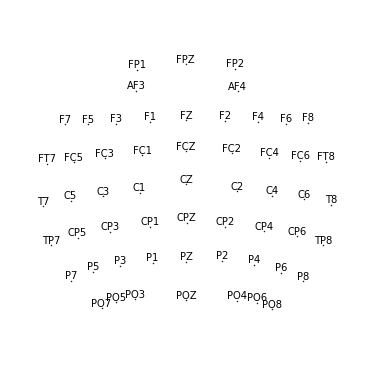

In [15]:

sensor = res.proportion_explained

sensor_plot = eelbrain.plot.SensorMap(res.h[0]) # plot all the channels
#topomap_plot = eelbrain.plot.Topomap(res.h[0], w=10, h=4)
print(res.h[0])


#p = eelbrain.plot.Topomap(res.h[0]('sensor',)) #,sensors=sensor, w=6, h=5)

#print(type(res.h[0]))
#timeINT = res.h[0].shape[2]
#print(type(time))
p = eelbrain.plot.TopoButterfly(res.h[0], w=10, h=4)
#p.set_time(.180)


In [23]:
temp_h0 = res.h[0]
dir(temp_h0)

['__abs__',
 '__add__',
 '__and__',
 '__array_interface__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__round__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',


In [29]:
temp_h0.frequency.values #==每個frequency band的mean

array([  72.16527455,  211.59617652,  415.61543108,  714.142197  ,
       1150.95503684, 1790.11198636, 2725.34458223, 4093.80347019])

In [31]:
temp_h0.x.sum(axis=1)  #依照axis=? (也就是矩陣的哪個axis)來計算 >> axis=1以band的來做

(57, 114)

In [32]:
temp_h0.x #.sum(axis=1)
# 重置回來的NDVar物件是要 NDVar(y, [montage, frequency(e.g. 256/8), time(UTS)], 'trf_name')
# Spectrogram by word class 那張圖，要看L2 & L1的族群比較>>後期分析要做

array([[[ 2.89120579e-20,  5.05961014e-20,  1.44560290e-20, ...,
          2.32142857e-04,  7.81250000e-05,  8.92857143e-06],
        [ 1.44560290e-20,  0.00000000e+00,  0.00000000e+00, ...,
          4.46428571e-04,  2.41071429e-04,  3.57142857e-05],
        [-1.44560290e-20,  7.22801448e-21,  3.43330688e-20, ...,
         -2.80085561e-20, -9.03501810e-21, -7.22801448e-21],
        ...,
        [ 2.16840434e-20,  0.00000000e+00, -7.22801448e-21, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.78241159e-20, -3.61400724e-20, -1.44560290e-20, ...,
          0.00000000e+00,  0.00000000e+00, -5.78241159e-20],
        [-2.89120579e-20, -1.80700362e-20, -1.44560290e-20, ...,
          5.78241159e-20,  2.89120579e-20,  9.39641883e-20]],

       [[-1.44560290e-20,  4.33680869e-20,  1.80700362e-20, ...,
          6.69642857e-04,  3.61607143e-04,  5.35714286e-05],
        [-8.92857143e-06, -6.02678571e-05, -1.11607143e-04, ...,
          2.05546662e-20, -5.10016177e

## ESLs Word-class-acoustics TRFs

##### Pre-define models here to have easier access during estimation. In the future, additional models could be added here and the script re-run to generate additional TRFs.
models = {
        
        # Acoustic models
        'envelope': [envelope],
        'envelope+onset': [envelope, onset_envelope],
        'acoustic': [gammatone, gammatone_onsets],
        
        # Models with word-onsets and word-class
        'words': [word_onsets],
        'words+lexical': [word_onsets, word_lexical, word_nlexical],  #covariant model
        'acoustic+words': [gammatone, gammatone_onsets, word_onsets],
        'acoustic+words+lexical': [gammatone, gammatone_onsets, word_onsets, word_lexical, word_nlexical],
        
        # Language Models
        'Ngram': [word_Ngram, word_onsets, word_lexical, word_nlexical],
        'CFG': [word_CFG, word_onsets, word_lexical, word_nlexical],
        'Ngram-CFG_all': [word_Ngram, word_CFG, word_onsets, word_lexical, word_nlexical]
    }
m = covar  
m1 = covar + Ngram  
m2 = covar + CFG  
m3 = covar + Ngram + CFG  

In [3]:
## ESLs ##

#STIMULI = [str(i) for i in range(1, 13)]
DATA_ROOT = Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
#PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
#PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]  #S01_alice-raw.fif
# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TRF_DIR.mkdir(exist_ok=True)
print(ESL_SUBJECTS)
print(len(ESL_SUBJECTS))  # 26

DST = TRF_DIR / 'ESLs_figures'
DST.mkdir(exist_ok=True)

['n_2_S019_ICAed_raw.fif', 'n_2_S020_ICAed_raw.fif', 'n_2_S021_ICAed_raw.fif', 'n_2_S022_ICAed_raw.fif', 'n_2_S023_ICAed_raw.fif', 'n_2_S026_ICAed_raw.fif', 'n_2_S024_ICAed_raw.fif', 'n_2_S012_ICAed_raw.fif', 'n_2_S013_ICAed_raw.fif', 'n_2_S015_ICAed_raw.fif', 'n_2_S016_ICAed_raw.fif', 'n_2_S011_ICAed_raw.fif', 'n_2_S010_ICAed_raw.fif', 'n_2_S029_ICAed_raw.fif', 'n_2_S027_ICAed_raw.fif', 'n_2_S028_ICAed_raw.fif', 'n_2_S030_ICAed_raw.fif', 'n_2_S031_ICAed_raw.fif', 'n_2_S017_ICAed_raw.fif', 'n_2_S025_ICAed_raw.fif', 'n_2_S032_ICAed_raw.fif', 'n_2_S034_ICAed_raw.fif', 'n_2_S035_ICAed_raw.fif', 'n_2_S036_ICAed_raw.fif', 'n_2_S038_ICAed_raw.fif', 'n_2_S039_ICAed_raw.fif']
26


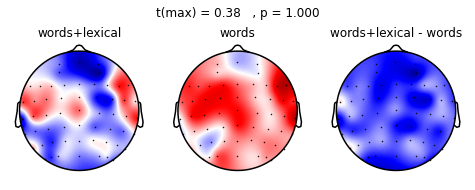

In [23]:
# Where to save the figure
# # Do brain responses differ between word class?
# Test whether adding predcitors that distinguish function and content words improves the predictive power of the TRF models.

# Load predictive power of all models
models = ['words', 'words+lexical', 'acoustic+words', 'acoustic+words+lexical']
rows = []
for model in models:
    for subject in ESL_SUBJECTS:
        trf = eelbrain.load.unpickle(TRF_DIR / subject[4:8] / f'{subject[4:8]} {model}.pickle')
        rows.append([subject, model, trf.proportion_explained])
model_data = eelbrain.Dataset.from_caselist(['subject', 'model', 'det'], rows)
# For more interpretable numbers, express proportion explained in terms of the maximum explained variability of the most complete model
index = model_data['model'] == 'acoustic+words+lexical'
model_data['det'] *= 100 / model_data[index, 'det'].mean('case').max('sensor')

lexical_model_test = eelbrain.testnd.TTestRelated('det', 'model', 'words+lexical', 'words', match='subject', ds=model_data, tail=1, pmin=0.05)
p12 = eelbrain.plot.Topomap(lexical_model_test, ncol=3, title=lexical_model_test, axh=2, clip='circle')
p12.save(DST / 'ESLs_acoustic+words+lexical_TRF_topo.png')

<TTestRelated 'non_lexical', 'lexical' (n=26), tail=1, samples=10000, pmin=0.05, tstart=0, 62 clusters, p = .005>
id   n_sensors   tstart   tstop   duration   v        p        sig
------------------------------------------------------------------
2    49          0.55     0.78    0.23       606.72   0.0053   ** 
<TTestOneSample 'non_lexical', match='subject', tail=1, samples=10000, pmin=0.05, tstart=0, 58 clusters, p < .001>
id   n_sensors   tstart   tstop   duration   v        p   sig
-------------------------------------------------------------
1    51          0.3      0.72    0.42       2081.4   0   ***
<TTestOneSample 'lexical', match='subject', tail=1, samples=10000, pmin=0.05, tstart=0, 31 clusters, p < .001>
id   n_sensors   tstart        tstop   duration   v        p   sig
------------------------------------------------------------------
1    55          -1.3878e-17   0.51    0.51       2229.4   0   ***


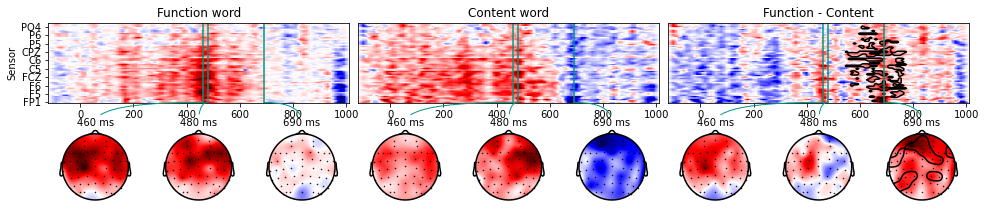

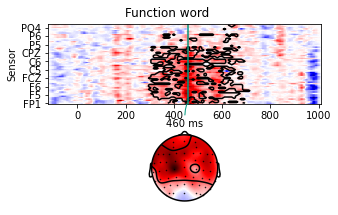

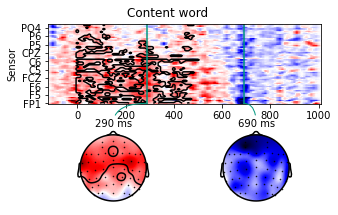

In [31]:
# ## How do the responses differ?
# Compare the TRFs corresponding to content and function words.

# Load the TRFs:
# Keep `h_scaled` instead of `h` so that we can compare and add TRFs to different predictors
# Because each predictor gets normalized for estimation, the scale of the TRFs in `h` are all different
# The `h_scaled` attribute reverses that normalization, so that the TRFs are all in a common scale
rows = []
for subject in ESL_SUBJECTS:
    trf = eelbrain.load.unpickle(TRF_DIR / subject[4:8] / f'{subject[4:8]} words+lexical.pickle')
    rows.append([subject, model, *trf.h_scaled])
trfs = eelbrain.Dataset.from_caselist(['subject', 'model', *trf.x], rows)

# Each word has an impulse of the general word predictor, as well as one form the word-class specific predictor
# Accordingly, each word's response consists of the general word TRF and the word-class specific TRF
# To reconstruct the responses to the two kinds of words, we thus want to add the general word TRF and the word-class specific TRF:
word_difference = eelbrain.testnd.TTestRelated('non_lexical + word', 'lexical + word', ds=trfs, tail=1, tstart=0, pmin=0.05)
function_Onesamtest = eelbrain.testnd.TTestOneSample('non_lexical', match='subject', ds=trfs, tail=1, tstart=0, pmin=0.05)
content_Onesamtest = eelbrain.testnd.TTestOneSample('lexical', match='subject', ds=trfs, tail=1, tstart=0, pmin=0.05)

word_diff_clus = word_difference.find_clusters(0.05)
function_clus = function_Onesamtest.find_clusters(0.05)
content_clus = content_Onesamtest.find_clusters(0.05)

print(word_difference)
print(word_diff_clus)
print(function_Onesamtest)
print(function_clus)
print(content_Onesamtest)
print(content_clus)

p13 = eelbrain.plot.TopoArray(word_difference, axtitle=["Function word", "Content word", "Function - Content"], t=[0.46, 0.48, 0.69], clip='circle')  #original_t=[0.100, 0.220, 0.400]
p14 = eelbrain.plot.TopoArray(function_Onesamtest, title="Function word", t=[0.46], clip='circle')
p15 = eelbrain.plot.TopoArray(content_Onesamtest, title="Content word", t=[0.29, 0.69], clip='circle')

p13.save(DST / 'ESLs_Islexical_TRF.png')
p14.save(DST / 'ESLs_Function_word_TRF.png')
p15.save(DST / 'ESLs_Content_word_TRF.png')

## ESLs POS-Models TRFs

##### Pre-define models here to have easier access during estimation. In the future, additional models could be added here and the script re-run to generate additional TRFs.
    models = {
        # Acoustic models
        'envelope': [envelope],
        'envelope+onset': [envelope, onset_envelope],
        'acoustic': [gammatone, gammatone_onsets],
        
        # Models with word-onsets and word-class
        'words': [word_onsets],
        'words+lexical': [word_onsets, word_lexical, word_nlexical],  # THIS IS THE m=covar
        'acoustic+words': [gammatone, gammatone_onsets, word_onsets],
        'acoustic+words+lexical': [gammatone, gammatone_onsets, word_onsets, word_lexical, word_nlexical],
        
        # Language Models
        'Ngram': [word_Ngram, word_onsets, word_lexical, word_nlexical],
        'CFG': [word_CFG, word_onsets, word_lexical, word_nlexical],
        'Ngram-CFG_all': [word_Ngram, word_CFG, word_onsets, word_lexical, word_nlexical]
    }
m = covar   ##[word_onsets, word_lexical, word_nlexical]  
m1 = covar + Ngram  
m2 = covar + CFG  
m3 = covar + Ngram + CFG  

In [3]:
## ESLs ##

#STIMULI = [str(i) for i in range(1, 13)]
DATA_ROOT = Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
#PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
#PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]  #S01_alice-raw.fif
# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TRF_DIR.mkdir(exist_ok=True)
print(ESL_SUBJECTS)
print(len(ESL_SUBJECTS))  # 26

DST = TRF_DIR / 'ESLs_figures'
DST.mkdir(exist_ok=True)

['n_2_S019_ICAed_raw.fif', 'n_2_S020_ICAed_raw.fif', 'n_2_S021_ICAed_raw.fif', 'n_2_S022_ICAed_raw.fif', 'n_2_S023_ICAed_raw.fif', 'n_2_S026_ICAed_raw.fif', 'n_2_S024_ICAed_raw.fif', 'n_2_S012_ICAed_raw.fif', 'n_2_S013_ICAed_raw.fif', 'n_2_S015_ICAed_raw.fif', 'n_2_S016_ICAed_raw.fif', 'n_2_S011_ICAed_raw.fif', 'n_2_S010_ICAed_raw.fif', 'n_2_S029_ICAed_raw.fif', 'n_2_S027_ICAed_raw.fif', 'n_2_S028_ICAed_raw.fif', 'n_2_S030_ICAed_raw.fif', 'n_2_S031_ICAed_raw.fif', 'n_2_S017_ICAed_raw.fif', 'n_2_S025_ICAed_raw.fif', 'n_2_S032_ICAed_raw.fif', 'n_2_S034_ICAed_raw.fif', 'n_2_S035_ICAed_raw.fif', 'n_2_S036_ICAed_raw.fif', 'n_2_S038_ICAed_raw.fif', 'n_2_S039_ICAed_raw.fif']
26


<TTestRelated 'det', 'model', 'Ngram', 'words+lexical', 'subject' (n=26), tail=1, samples=10000, pmin=0.05, 2 clusters, p = .209>
id   n_sensors   v   p   sig
----------------------------
<TTestRelated 'det', 'model', 'CFG', 'words+lexical', 'subject' (n=26), tail=1, samples=10000, pmin=0.05, 2 clusters, p = .751>
id   n_sensors   v   p   sig
----------------------------
<TTestRelated 'det', 'model', 'Ngram', 'CFG', 'subject' (n=26), tail=1, samples=10000, pmin=0.05, 2 clusters, p = .114>
id   n_sensors   v   p   sig
----------------------------


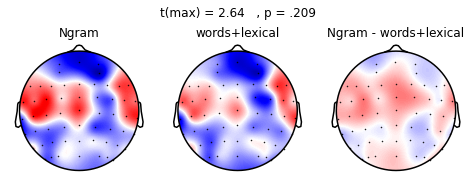

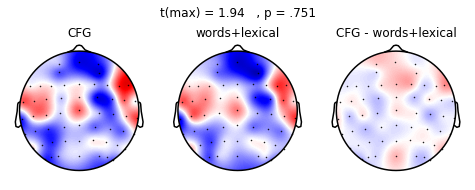

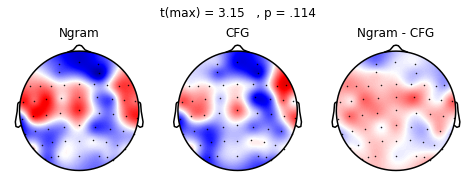

In [5]:
# Load predictive power of all models
models = ['words+lexical', 'Ngram', 'CFG', 'Ngram-CFG_all']
rowsLIST = []
for model in models:
    for subject in ESL_SUBJECTS:
        trf = eelbrain.load.unpickle(TRF_DIR / subject[4:8] / f'{subject[4:8]} {model}.pickle')
        rowsLIST.append([subject, model, trf.proportion_explained])
model_data = eelbrain.Dataset.from_caselist(['subject', 'model', 'det'], rowsLIST)

# For more interpretable numbers, express proportion explained in terms of the maximum explained variability of the most complete model
index = model_data['model'] == 'Ngram-CFG_all'
model_data['det'] *= 100 / model_data[index, 'det'].mean('case').max('sensor')

 # OLD commands(Dich it for now)
Ngram_model_test = eelbrain.testnd.TTestRelated('det', 'model', 'Ngram', 'words+lexical', match='subject', ds=model_data, tail=1, pmin=0.05)
CFG_model_test = eelbrain.testnd.TTestRelated('det', 'model', 'CFG', 'words+lexical', match='subject', ds=model_data, tail=1, pmin=0.05)
NgramCFG_model_test = eelbrain.testnd.TTestRelated('det', 'model', 'Ngram', 'CFG', match='subject', ds=model_data, tail=1, pmin=0.05)

Ngram_ttrelated_clus = Ngram_model_test.find_clusters(0.05)
CFG_ttrelated_clus = CFG_model_test.find_clusters(0.05)
NgramCFG_ttrelated_clus = NgramCFG_model_test.find_clusters(0.05)

print(Ngram_model_test)
print(Ngram_ttrelated_clus)
print(CFG_model_test)
print(CFG_ttrelated_clus)
print(NgramCFG_model_test)
print(NgramCFG_ttrelated_clus)

p18 = eelbrain.plot.Topomap(Ngram_model_test, ncol=3, title=Ngram_model_test, axh=2, clip='circle')
p19 = eelbrain.plot.Topomap(CFG_model_test, ncol=3, title=CFG_model_test, axh=2, clip='circle')
p20 = eelbrain.plot.Topomap(NgramCFG_model_test, ncol=3, title=NgramCFG_model_test, axh=2, clip='circle')

p18.save(DST / 'ESLs_Ngram_TRF_topo.png')
p19.save(DST / 'ESLs_CFG_TRF_topo.png')
p20.save(DST / 'ESLs_NgramCFG_TRF_topo.png')

<TTestOneSample 'ngram', match='subject', tail=1, samples=10000, pmin=0.05, tstart=0, 42 clusters, p < .001>
id   n_sensors   tstart   tstop   duration   v        p   sig
-------------------------------------------------------------
2    52          0.04     0.68    0.64       2506.9   0   ***
<TTestOneSample 'cfg', match='subject', tail=1, samples=10000, pmin=0.05, tstart=0, 37 clusters, p < .001>
id   n_sensors   tstart   tstop   duration   v        p   sig
-------------------------------------------------------------
2    48          0.25     0.71    0.46       1526.6   0   ***
<TTestRelated 'ngram', 'cfg' (n=26), tail=1, samples=10000, pmin=0.05, tstart=0, 81 clusters, p = .002>
id   n_sensors   tstart   tstop   duration   v        p        sig
------------------------------------------------------------------
2    39          0.14     0.36    0.22       460.09   0.0016   ** 


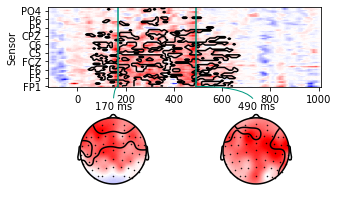

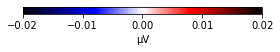

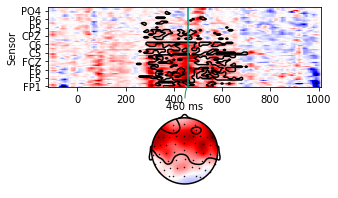

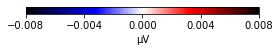

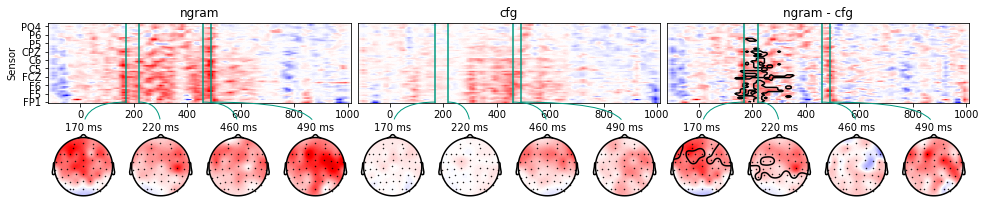

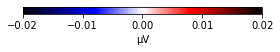

In [21]:
# ## How do the responses differ?
# Compare the TRFs corresponding to Ngram, CFG , and combined(Ngram+CFG).

# Load the TRFs:
# Keep `h_scaled` instead of `h` so that we can compare and add TRFs to different predictors
# Because each predictor gets normalized for estimation, the scale of the TRFs in `h` are all different
# The `h_scaled` attribute reverses that normalization, so that the TRFs are all in a common scale
rows = []
for subject in ESL_SUBJECTS:
    trf = eelbrain.load.unpickle(TRF_DIR / subject[4:8] / f'{subject[4:8]} Ngram-CFG_all.pickle')
    trf.x = ['ngram', 'cfg', 'word', 'lexical', 'non_lexical'] #rename the n-gram model
    rows.append([subject, model, *trf.h_scaled])
trfs = eelbrain.Dataset.from_caselist(['subject', 'model', *trf.x], rows)
#pprint(rows)

# redo the t-test (use one-sample to see effects from Ngram & CFG, because it is m1/m2 - m >>)
Ngram_Onesamtest = eelbrain.testnd.TTestOneSample('ngram', match='subject', ds=trfs, tail=1, tstart=0, pmin=0.05)
CFG_Onesamtest = eelbrain.testnd.TTestOneSample('cfg', match='subject', ds=trfs, tail=1, tstart=0, pmin=0.05)
NgramCFG_pairedttest = eelbrain.testnd.TTestRelated('ngram', 'cfg', ds=trfs, tail=1, tstart=0, pmin=0.05)  #, match='subject'
# (Done_like regression)Q: Tail >> set 0(two-tailed) or 1 (upper_one-tailed)?
# Q:Why we close the "subject", then it's ok >> match = None??

# Find the sig clusters
Ngram_Onesamtest_clus = Ngram_Onesamtest.find_clusters(0.05)
CFG_Onesamtest_clus = CFG_Onesamtest.find_clusters(0.05)
NgramCFG_pairedttest_clus = NgramCFG_pairedttest.find_clusters(0.05)

# Print out the Stats and its clusters
print(Ngram_Onesamtest)
print(Ngram_Onesamtest_clus)
print(CFG_Onesamtest)
print(CFG_Onesamtest_clus)
print(NgramCFG_pairedttest)
print(NgramCFG_pairedttest_clus)

# Plot the topoarray of model
p21_Ngram = eelbrain.plot.TopoArray(Ngram_Onesamtest, t=[0.17, 0.49], clip='circle') 
p21_Ngram.plot_colorbar(width=0.1)
p22_CFG = eelbrain.plot.TopoArray(CFG_Onesamtest, t=[0.46], clip='circle') 
p22_CFG.plot_colorbar(width=0.1)
p23_ALL = eelbrain.plot.TopoArray(NgramCFG_pairedttest, t=[0.17, 0.22, 0.46, 0.49], clip='circle') 
p23_ALL.plot_colorbar(width=0.1)

p21_Ngram.save(DST / 'ESLs_Ngram_TRF.png')
p22_CFG.save(DST / 'ESLs_CFG_TRF.png')
p23_ALL.save(DST / 'ESLs_NgramCFG_TRF.png')

## ESL IF TRFs (all six IMFs)

##### Pre-define models here to have easier access during estimation. In the future, additional models could be added here and the script re-run to generate additional TRFs.
    models = {
           # Acoustic models
    'envelope': [envelope],
    'envelope+onset': [envelope, onset_envelope],
    'acoustic': [gammatone, gammatone_onsets],
    # Models with word-onsets and word-class
    'words': [word_onsets],
    'words+lexical': [word_onsets, word_lexical, word_nlexical],
    'acoustic+words': [gammatone, gammatone_onsets, word_onsets],
    'acoustic+words+lexical': [gammatone, gammatone_onsets, word_onsets, word_lexical, word_nlexical],
    # Language Models
    'Ngram': [word_Ngram, word_onsets, word_lexical, word_nlexical],
    'CFG': [word_CFG, word_onsets, word_lexical, word_nlexical],
    'Ngram-CFG_all': [word_Ngram, word_CFG, word_onsets, word_lexical, word_nlexical],
    
    # IFs
    'IMF1':[imf1],
    'IMF12':[imf1, imf2],
    'IMF123':[imf1, imf2, imf3],
    'IMF1234':[imf1, imf2, imf3, imf4],
    'IMF12345':[imf1, imf2, imf3, imf4, imf5],
    'IMFAll':[imf1, imf2, imf3, imf4, imf5, imf6],

    # F0
    'Fzero+envelope': [F_zero]
    'Fzero+envelope': [envelope, onset_envelope, F_zero]

    # All auditory features model
    'All_model':[envelope, onset_envelope, word_onsets, word_lexical, word_nlexical]
    #'All_Aud_model':[envelope, onset_envelope, word_onsets, word_lexical, word_nlexical, imf1, imf2, imf3, imf4, imf5, imf6, F_zero]
    # All model
    #'All_model':[envelope, onset_envelope, word_onsets, word_lexical, word_nlexical, word_CFG, word_Ngramm, imf_1, imf_2, imf_3, imf_4, imf_5, imf_6, F_zero]
    }
m = covar  
m1 = covar + Ngram  
m2 = covar + CFG  
m3 = covar + Ngram + CFG  

In [3]:
## ESLs ##
#STIMULI = [str(i) for i in range(1, 13)]
#DATA_ROOT = Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
#PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
#PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
IMF_DIR = DATA_ROOT/ "TRFs_pridictors/IF_predictors"
IMFsLIST = [path.name for path in IMF_DIR.iterdir() if re.match(r'Alice_IF_IMF_*', path.name)] 
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]  #S01_alice-raw.fif

# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TRF_DIR.mkdir(exist_ok=True)
print(ESL_SUBJECTS)
print(len(ESL_SUBJECTS))  # 26
DST = TRF_DIR / 'ESLs_figures'
DST.mkdir(exist_ok=True)

['n_2_S030_ICAed_raw.fif', 'n_2_S027_ICAed_raw.fif', 'n_2_S023_ICAed_raw.fif', 'n_2_S034_ICAed_raw.fif', 'n_2_S024_ICAed_raw.fif', 'n_2_S019_ICAed_raw.fif', 'n_2_S020_ICAed_raw.fif', 'n_2_S013_ICAed_raw.fif', 'n_2_S017_ICAed_raw.fif', 'n_2_S039_ICAed_raw.fif', 'n_2_S010_ICAed_raw.fif', 'n_2_S029_ICAed_raw.fif', 'n_2_S015_ICAed_raw.fif', 'n_2_S028_ICAed_raw.fif', 'n_2_S011_ICAed_raw.fif', 'n_2_S038_ICAed_raw.fif', 'n_2_S016_ICAed_raw.fif', 'n_2_S012_ICAed_raw.fif', 'n_2_S021_ICAed_raw.fif', 'n_2_S036_ICAed_raw.fif', 'n_2_S032_ICAed_raw.fif', 'n_2_S025_ICAed_raw.fif', 'n_2_S035_ICAed_raw.fif', 'n_2_S022_ICAed_raw.fif', 'n_2_S026_ICAed_raw.fif', 'n_2_S031_ICAed_raw.fif']
26


In [4]:
# ## How do the responses differ?
# Compare the TRFs corresponding to all individual IMFs, and combined(IMF_ALL).

# Build the model_data['model']
models = ['IMF1', 'IMF12', 'IMF123', 'IMF1234', 'IMF12345', 'IMFAll']
rowsLIST = []
for model in models:
    print(model)
    for subject in ESL_SUBJECTS:
        trf = eelbrain.load.unpickle(TRF_DIR / subject[4:8] / f'{subject[4:8]} {model}.pickle')
        #print(trf)
        trf.x = ['imf1', 'imf2', 'imf3', 'imf4', 'imf5', 'imfall'] #rename the model (no punctuation)
        rowsLIST.append([subject, model, trf.proportion_explained])
model_data = eelbrain.Dataset.from_caselist(['subject', 'model', 'det'], rowsLIST)
#pprint(rows)
print(model_data)

# For more interpretable numbers, express proportion explained in terms of the maximum explained variability of the most complete model
index = model_data['model'] == 'IMFAll'
model_data['det'] *= 100 / model_data[index, 'det'].mean('case').max('sensor')
# ['IMF_6', 'IMF_4', 'IMF_2', 'IMF_5', 'IMF_1', 'IMF_3'] >> the supposed model names??  >> why would IMF_6 popped up??

IMF1
IMF12
IMF123
IMF1234
IMF12345
IMFAll
subject                  model   
---------------------------------
n_2_S030_ICAed_raw.fif   IMF1    
n_2_S027_ICAed_raw.fif   IMF1    
n_2_S023_ICAed_raw.fif   IMF1    
n_2_S034_ICAed_raw.fif   IMF1    
n_2_S024_ICAed_raw.fif   IMF1    
n_2_S019_ICAed_raw.fif   IMF1    
n_2_S020_ICAed_raw.fif   IMF1    
n_2_S013_ICAed_raw.fif   IMF1    
n_2_S017_ICAed_raw.fif   IMF1    
n_2_S039_ICAed_raw.fif   IMF1    
n_2_S010_ICAed_raw.fif   IMF1    
n_2_S029_ICAed_raw.fif   IMF1    
n_2_S015_ICAed_raw.fif   IMF1    
n_2_S028_ICAed_raw.fif   IMF1    
n_2_S011_ICAed_raw.fif   IMF1    
n_2_S038_ICAed_raw.fif   IMF1    
n_2_S016_ICAed_raw.fif   IMF1    
n_2_S012_ICAed_raw.fif   IMF1    
n_2_S021_ICAed_raw.fif   IMF1    
n_2_S036_ICAed_raw.fif   IMF1    
n_2_S032_ICAed_raw.fif   IMF1    
n_2_S025_ICAed_raw.fif   IMF1    
n_2_S035_ICAed_raw.fif   IMF1    
n_2_S022_ICAed_raw.fif   IMF1    
n_2_S026_ICAed_raw.fif   IMF1    
n_2_S031_ICAed_raw.fif   IMF1    
n_2_S0

subject                  model 
-------------------------------
n_2_S030_ICAed_raw.fif   IMFAll
n_2_S027_ICAed_raw.fif   IMFAll
n_2_S023_ICAed_raw.fif   IMFAll
n_2_S034_ICAed_raw.fif   IMFAll
n_2_S024_ICAed_raw.fif   IMFAll
n_2_S019_ICAed_raw.fif   IMFAll
n_2_S020_ICAed_raw.fif   IMFAll
n_2_S013_ICAed_raw.fif   IMFAll
n_2_S017_ICAed_raw.fif   IMFAll
n_2_S039_ICAed_raw.fif   IMFAll
n_2_S010_ICAed_raw.fif   IMFAll
n_2_S029_ICAed_raw.fif   IMFAll
n_2_S015_ICAed_raw.fif   IMFAll
n_2_S028_ICAed_raw.fif   IMFAll
n_2_S011_ICAed_raw.fif   IMFAll
n_2_S038_ICAed_raw.fif   IMFAll
n_2_S016_ICAed_raw.fif   IMFAll
n_2_S012_ICAed_raw.fif   IMFAll
n_2_S021_ICAed_raw.fif   IMFAll
n_2_S036_ICAed_raw.fif   IMFAll
n_2_S032_ICAed_raw.fif   IMFAll
n_2_S025_ICAed_raw.fif   IMFAll
n_2_S035_ICAed_raw.fif   IMFAll
n_2_S022_ICAed_raw.fif   IMFAll
n_2_S026_ICAed_raw.fif   IMFAll
n_2_S031_ICAed_raw.fif   IMFAll
-------------------------------
NDVars: imf1, imf2, imf3, imf4, imf5, imf6
<TTestOneSample 'imf1', match

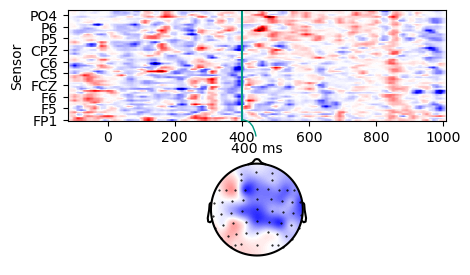

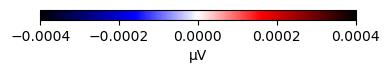

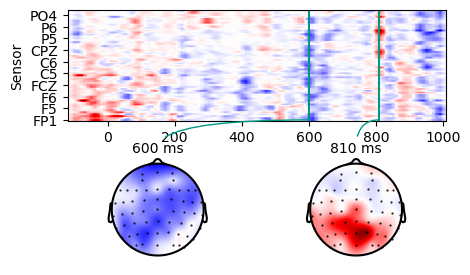

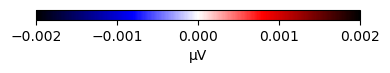

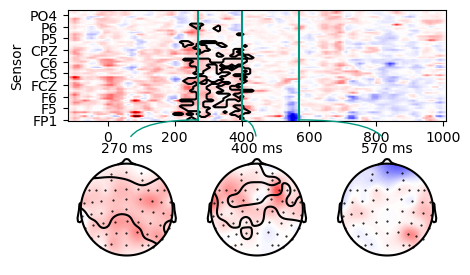

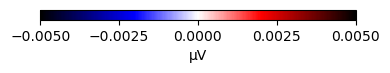

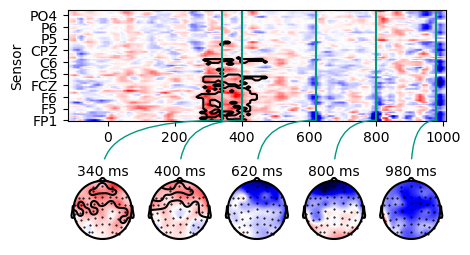

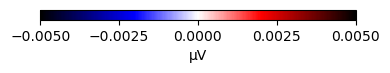

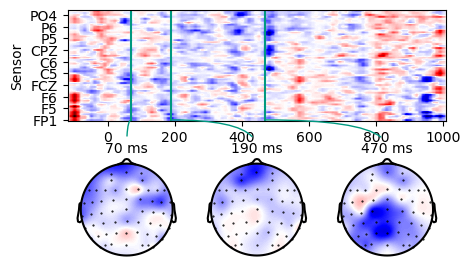

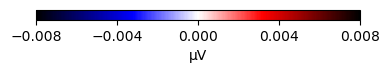

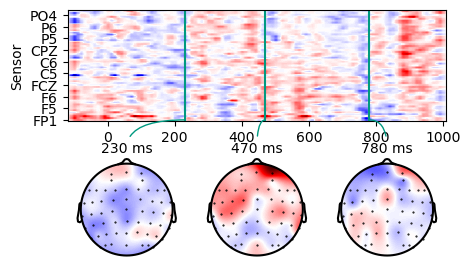

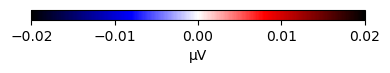

In [5]:
# Load the TRFs:
# Keep `h_scaled` instead of `h` so that we can compare and add TRFs to different predictors
# Because each predictor gets normalized for estimation, the scale of the TRFs in `h` are all different
# The `h_scaled` attribute reverses that normalization, so that the TRFs are all in a common scale

### FOR each IMFs (one sample so far)###
n_rows = []
for subject in ESL_SUBJECTS:
    n_trf = eelbrain.load.unpickle(TRF_DIR / subject[4:8] / f'{subject[4:8]} IMFAll.pickle')
    #print(n_trf.x)  # old: ['IMF_6', 'IMF_4', 'IMF_2', 'IMF_5', 'IMF_1', 'IMF_3']
    n_trf.x = ['imf1', 'imf2', 'imf3', 'imf4', 'imf5', 'imf6'] #rename the model (no punctuation)
    n_rows.append([subject, model, *n_trf.h_scaled])
n_trfs = eelbrain.Dataset.from_caselist(['subject', 'model', *n_trf.x], n_rows)
print(n_trfs)


# redo the t-test (use one-sample to see effects from Ngram & CFG, because it is m1/m2 - m >>)
IMF1_Onesamtest = eelbrain.testnd.TTestOneSample('imf1', match='subject', ds=n_trfs, tail=1, tstart=0, pmin=0.05)
IMF2_Onesamtest = eelbrain.testnd.TTestOneSample('imf2', match='subject', ds=n_trfs, tail=1, tstart=0, pmin=0.05)
IMF3_Onesamtest = eelbrain.testnd.TTestOneSample('imf3', match='subject', ds=n_trfs, tail=1, tstart=0, pmin=0.05)
IMF4_Onesamtest = eelbrain.testnd.TTestOneSample('imf4', match='subject', ds=n_trfs, tail=1, tstart=0, pmin=0.05)
IMF5_Onesamtest = eelbrain.testnd.TTestOneSample('imf5', match='subject', ds=n_trfs, tail=1, tstart=0, pmin=0.05)
IMF6_Onesamtest = eelbrain.testnd.TTestOneSample('imf6', match='subject', ds=n_trfs, tail=1, tstart=0, pmin=0.05)

#IMF_all_pairedttest = eelbrain.testnd.TTestRelated('imf1', 'imf12', 'imf123', 'imf1234', 'imf12345', 'imfAll', ds=n_trfs, tail=1, tstart=0, pmin=0.05)  #, match='subject'
# Tail >> set 0(two-tailed) or 1 (upper_one-tailed)?  ; Why we close the "subject", then it's ok >> match = None??

# Find the sig clusters
IMF1_Onesamtest_clus =IMF1_Onesamtest.find_clusters(0.05)
IMF2_Onesamtest_clus =IMF2_Onesamtest.find_clusters(0.05)
IMF3_Onesamtest_clus =IMF3_Onesamtest.find_clusters(0.05)
IMF4_Onesamtest_clus =IMF4_Onesamtest.find_clusters(0.05)
IMF5_Onesamtest_clus =IMF5_Onesamtest.find_clusters(0.05)
IMF6_Onesamtest_clus =IMF6_Onesamtest.find_clusters(0.05)

#IMF_all_pairedttest_clus =IMF_all_pairedttest.find_clusters(0.05)

# Print out the Stats and its clusters
print(IMF1_Onesamtest)
print(IMF1_Onesamtest_clus)
print(IMF2_Onesamtest)
print(IMF2_Onesamtest_clus)
print(IMF3_Onesamtest)
print(IMF3_Onesamtest_clus)
print(IMF4_Onesamtest)
print(IMF4_Onesamtest_clus)
print(IMF5_Onesamtest)
print(IMF5_Onesamtest_clus)
print(IMF6_Onesamtest)
print(IMF6_Onesamtest_clus)

#print(IMF_all_pairedttest)
#print(IMF_all_pairedttest_clus)



# Plot the topoarray of model

p24_IMF_1 = eelbrain.plot.TopoArray(IMF1_Onesamtest, t=[0.40], clip='circle') 
p24_IMF_1.plot_colorbar(width=0.1)

p25_IMF_12 = eelbrain.plot.TopoArray(IMF2_Onesamtest, t=[0.60, 0.81], clip='circle') 
p25_IMF_12.plot_colorbar(width=0.1)

p26_IMF_123 = eelbrain.plot.TopoArray(IMF3_Onesamtest, t=[0.27, 0.40, 0.57], clip='circle') 
p26_IMF_123.plot_colorbar(width=0.1)

p27_IMF_1234 = eelbrain.plot.TopoArray(IMF4_Onesamtest, t=[0.34, 0.40, 0.62, 0.80, 0.98], clip='circle') 
p27_IMF_1234.plot_colorbar(width=0.1)

p28_IMF_12345 = eelbrain.plot.TopoArray(IMF5_Onesamtest, t=[0.07, 0.19, 0.47], clip='circle') 
p28_IMF_12345.plot_colorbar(width=0.1)

p29_IMF_All = eelbrain.plot.TopoArray(IMF6_Onesamtest, t=[0.23, 0.47, 0.78], clip='circle') 
p29_IMF_All.plot_colorbar(width=0.1)


#p30_All = eelbrain.plot.TopoArray(IMF_all_pairedttest, t=[0.21], clip='circle') 
#p30_All.plot_colorbar(width=0.1)


#"""
p24_IMF_1.save(DST / 'ESLs_IMF_1_TRF.png')
p25_IMF_12.save(DST / 'ESLs_IMF_2_TRF.png')
p26_IMF_123.save(DST / 'ESLs_IMF_3_TRF.png')
p27_IMF_1234.save(DST / 'ESLs_IMF_4_TRF.png')
p28_IMF_12345.save(DST / 'ESLs_IMF_5_TRF.png')
p29_IMF_All.save(DST / 'ESLs_IMF_6_TRF.png')
#"""

In [ ]:
"""
imf1 min = -29.9403 max = 49.8705 mean = 17.1827
imf2 min = -17.1891 max = 33.8395 mean = 7.6307
imf3 min = -15.5781 max = 29.1027 mean = 4.1004
imf4 min = -19.0941 max = 25.2857 mean = 2.1606
imf5 min = -21.1892 max = 19.7518 mean = 1.0657
imf6 min = -18.8191 max = 20.1623 mean = 0.5355
"""

<TTestRelated 'imf1', 'imf2' (n=26), tail=1, samples=10000, pmin=0.05, tstart=0, 58 clusters, p = .712>
id   n_sensors   tstart   tstop   duration   v   p   sig
--------------------------------------------------------
<TTestRelated 'imf2', 'imf3' (n=26), tail=1, samples=10000, pmin=0.05, tstart=0, 24 clusters, p = .204>
id   n_sensors   tstart   tstop   duration   v   p   sig
--------------------------------------------------------
<TTestRelated 'imf3', 'imf4' (n=26), tail=1, samples=10000, pmin=0.05, tstart=0, 50 clusters, p = .455>
id   n_sensors   tstart   tstop   duration   v   p   sig
--------------------------------------------------------
<TTestRelated 'imf4', 'imf5' (n=26), tail=1, samples=10000, pmin=0.05, tstart=0, 65 clusters, p = .020>
id   n_sensors   tstart   tstop   duration   v        p      sig
----------------------------------------------------------------
3    44          0.25     0.43    0.18       405.72   0.02   *  
<TTestRelated 'imf5', 'imf6' (n=26), tail=1, sa

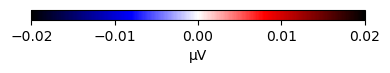

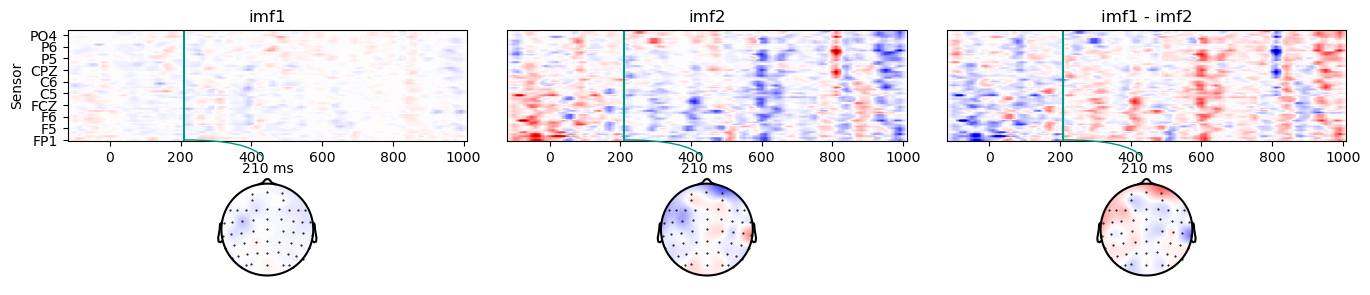

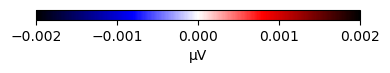

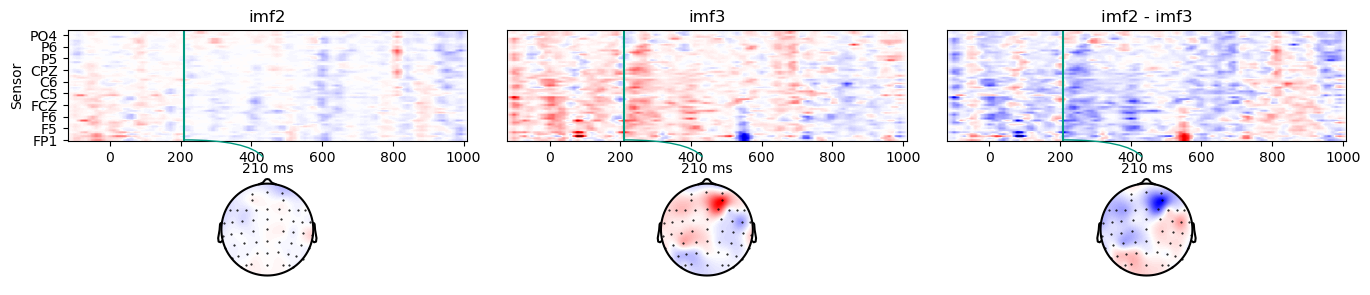

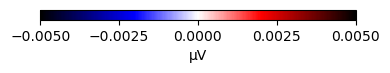

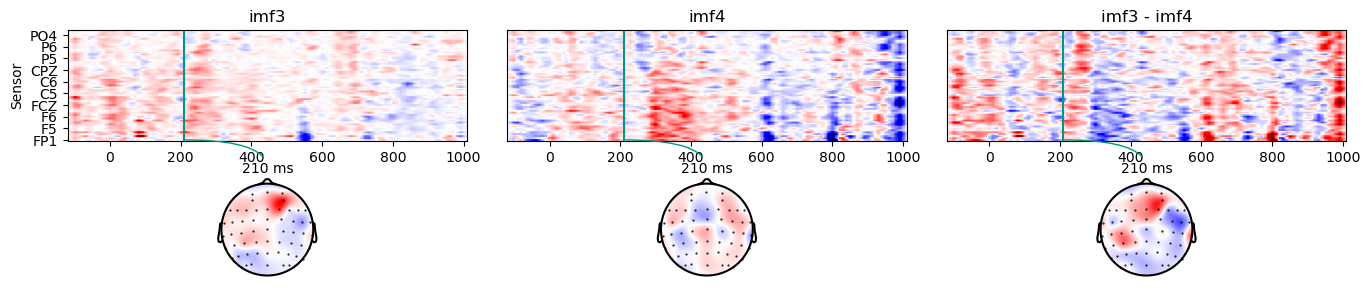

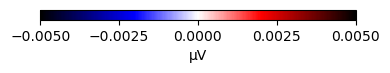

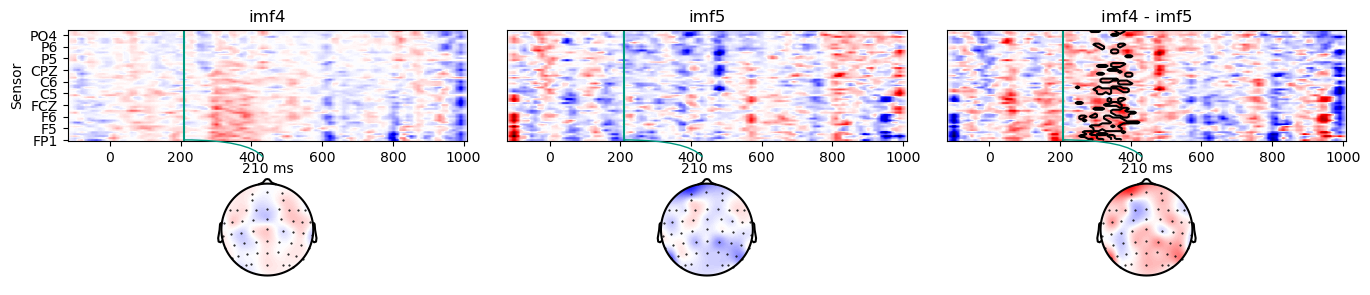

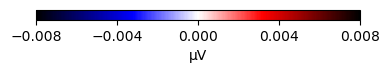

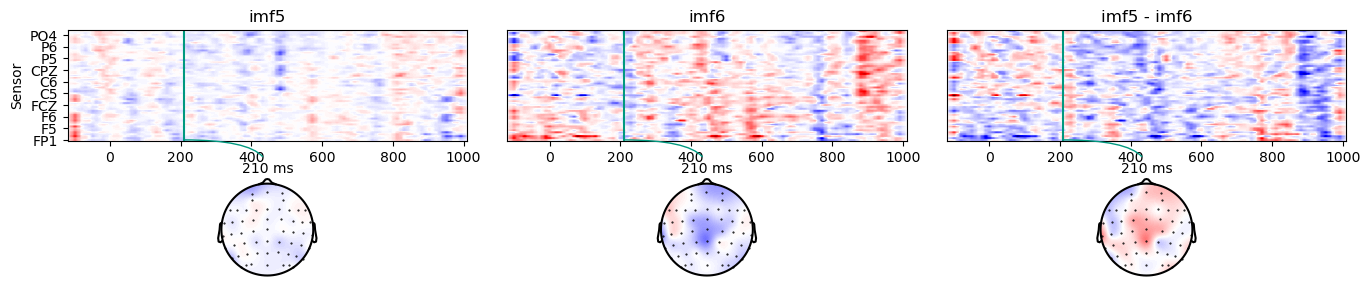

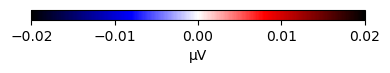

In [17]:
### FOR paired-t test of between IMFs ###

IMF_12_pairedttest = eelbrain.testnd.TTestRelated('imf1', 'imf2', ds=n_trfs, tail=1, tstart=0, pmin=0.05)  #, match='subject'
IMF_23_pairedttest = eelbrain.testnd.TTestRelated('imf2', 'imf3', ds=n_trfs, tail=1, tstart=0, pmin=0.05)  #, match='subject'
IMF_34_pairedttest = eelbrain.testnd.TTestRelated('imf3', 'imf4', ds=n_trfs, tail=1, tstart=0, pmin=0.05)  #, match='subject'
IMF_45_pairedttest = eelbrain.testnd.TTestRelated('imf4', 'imf5', ds=n_trfs, tail=1, tstart=0, pmin=0.05)  #, match='subject'
IMF_56_pairedttest = eelbrain.testnd.TTestRelated('imf5', 'imf6', ds=n_trfs, tail=1, tstart=0, pmin=0.05)  #, match='subject'
# Tail >> set 0(two-tailed) or 1 (upper_one-tailed)?  ; Why we close the "subject", then it's ok >> match = None??


IMF_12_pairedttest_clus =IMF_12_pairedttest.find_clusters(0.05)
IMF_23_pairedttest_clus =IMF_23_pairedttest.find_clusters(0.05)
IMF_34_pairedttest_clus =IMF_34_pairedttest.find_clusters(0.05)
IMF_45_pairedttest_clus =IMF_45_pairedttest.find_clusters(0.05)
IMF_56_pairedttest_clus =IMF_56_pairedttest.find_clusters(0.05)


print(IMF_12_pairedttest)
print(IMF_12_pairedttest_clus)
print(IMF_23_pairedttest)
print(IMF_23_pairedttest_clus)
print(IMF_34_pairedttest)
print(IMF_34_pairedttest_clus)
print(IMF_45_pairedttest)
print(IMF_45_pairedttest_clus)
print(IMF_56_pairedttest)
print(IMF_56_pairedttest_clus)

p31_imf12 = eelbrain.plot.TopoArray(IMF_12_pairedttest, t=[0.21], clip='circle') 
p31_imf12.plot_colorbar(width=0.1)
p32_imf23 = eelbrain.plot.TopoArray(IMF_23_pairedttest, t=[0.21], clip='circle') 
p32_imf23.plot_colorbar(width=0.1)
p33_imf34 = eelbrain.plot.TopoArray(IMF_34_pairedttest, t=[0.21], clip='circle') 
p33_imf34.plot_colorbar(width=0.1)
p34_imf45 = eelbrain.plot.TopoArray(IMF_45_pairedttest, t=[0.21], clip='circle')  ## imf4-imf5 sig
p34_imf45.plot_colorbar(width=0.1)
p35_imf56 = eelbrain.plot.TopoArray(IMF_56_pairedttest, t=[0.21], clip='circle')  
p35_imf56.plot_colorbar(width=0.1)

<TTestRelated 'imf6', 'imf5' (n=26), tail=1, samples=10000, pmin=0.05, tstart=0, 69 clusters, p = .236>
id   n_sensors   tstart   tstop   duration   v   p   sig
--------------------------------------------------------
<TTestRelated 'imf5', 'imf4' (n=26), tail=1, samples=10000, pmin=0.05, tstart=0, 37 clusters, p = .492>
id   n_sensors   tstart   tstop   duration   v   p   sig
--------------------------------------------------------
<TTestRelated 'imf4', 'imf3' (n=26), tail=1, samples=10000, pmin=0.05, tstart=0, 59 clusters, p = .379>
id   n_sensors   tstart   tstop   duration   v   p   sig
--------------------------------------------------------
<TTestRelated 'imf3', 'imf2' (n=26), tail=1, samples=10000, pmin=0.05, tstart=0, 57 clusters, p = .003>
id   n_sensors   tstart   tstop   duration   v        p        sig
------------------------------------------------------------------
1    45          0.22     0.46    0.24       836.98   0.0034   ** 
11   33          0.52     0.75    0.23   

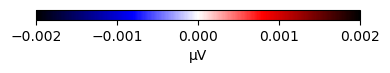

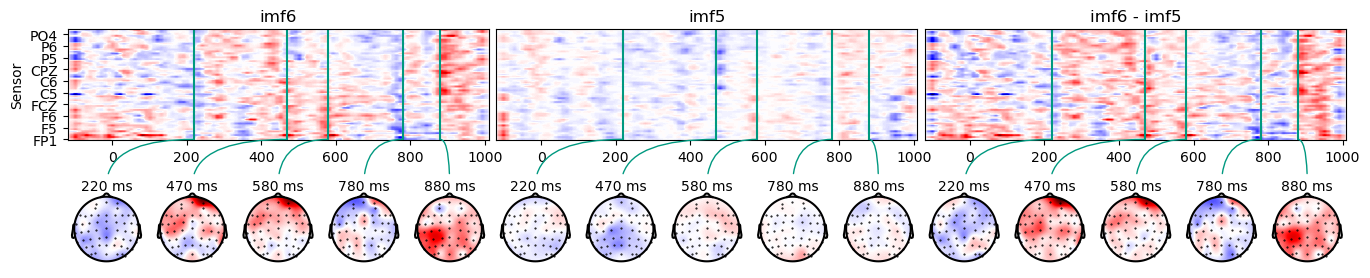

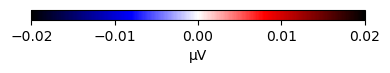

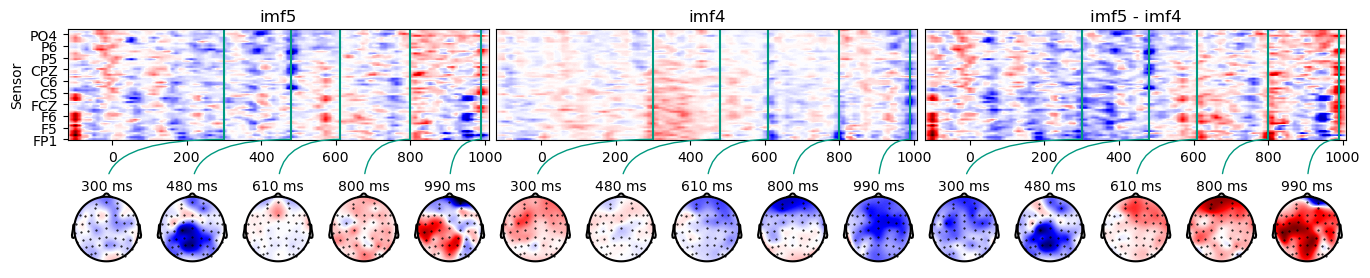

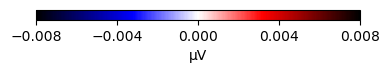

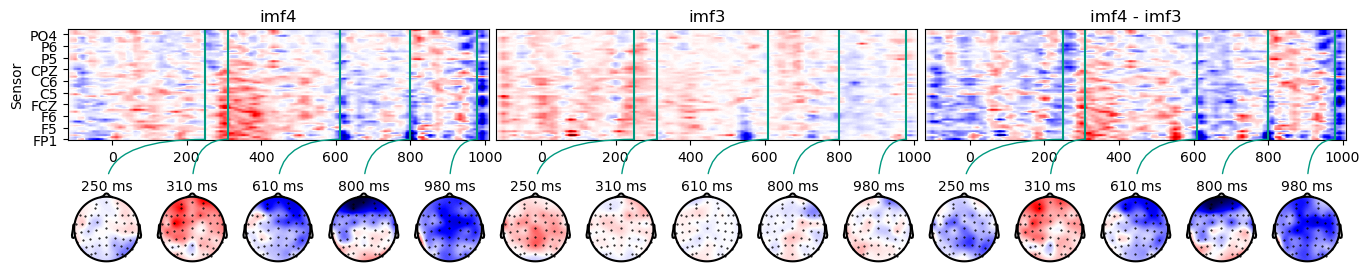

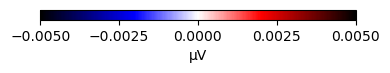

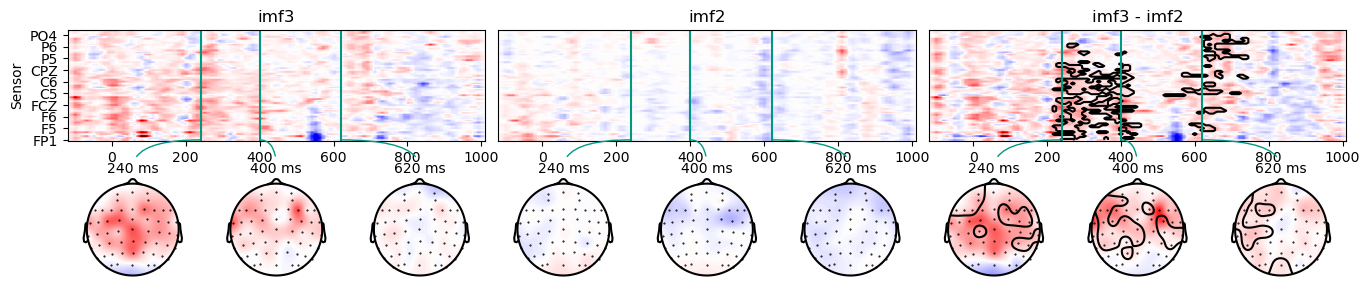

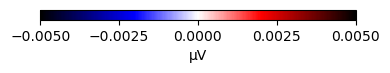

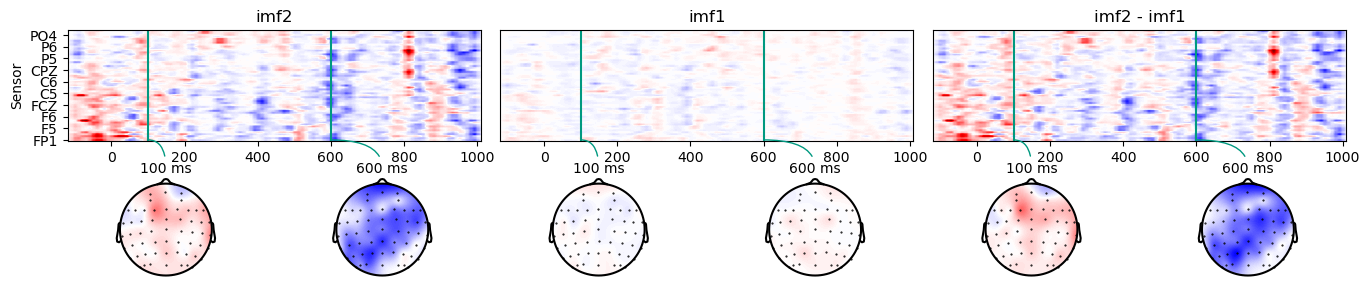

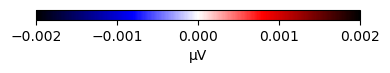

In [19]:
### FOR paired-t test of between IMFs part two ###

IMF_65_pairedttest = eelbrain.testnd.TTestRelated('imf6', 'imf5', ds=n_trfs, tail=1, tstart=0, pmin=0.05)  #, match='subject'
IMF_54_pairedttest = eelbrain.testnd.TTestRelated('imf5', 'imf4', ds=n_trfs, tail=1, tstart=0, pmin=0.05)  #, match='subject'
IMF_43_pairedttest = eelbrain.testnd.TTestRelated('imf4', 'imf3', ds=n_trfs, tail=1, tstart=0, pmin=0.05)  #, match='subject'
IMF_32_pairedttest = eelbrain.testnd.TTestRelated('imf3', 'imf2', ds=n_trfs, tail=1, tstart=0, pmin=0.05)  #, match='subject'
IMF_21_pairedttest = eelbrain.testnd.TTestRelated('imf2', 'imf1', ds=n_trfs, tail=1, tstart=0, pmin=0.05)  #, match='subject'
# Tail >> set 0(two-tailed) or 1 (upper_one-tailed)?  ; Why we close the "subject", then it's ok >> match = None??


IMF_65_pairedttest_clus =IMF_65_pairedttest.find_clusters(0.05)
IMF_54_pairedttest_clus =IMF_54_pairedttest.find_clusters(0.05)
IMF_43_pairedttest_clus =IMF_43_pairedttest.find_clusters(0.05)
IMF_32_pairedttest_clus =IMF_32_pairedttest.find_clusters(0.05)
IMF_21_pairedttest_clus =IMF_21_pairedttest.find_clusters(0.05)


print(IMF_65_pairedttest)
print(IMF_65_pairedttest_clus)
print(IMF_54_pairedttest)
print(IMF_54_pairedttest_clus)
print(IMF_43_pairedttest)
print(IMF_43_pairedttest_clus)
print(IMF_32_pairedttest)
print(IMF_32_pairedttest_clus)
print(IMF_21_pairedttest)
print(IMF_21_pairedttest_clus)

p31_imf65 = eelbrain.plot.TopoArray(IMF_65_pairedttest, t=[0.22, 0.47, 0.58, 0.78, 0.88], clip='circle') 
p31_imf65.plot_colorbar(width=0.1)
p32_imf54 = eelbrain.plot.TopoArray(IMF_54_pairedttest, t=[0.3, 0.48, 0.61, 0.8, 0.99], clip='circle') 
p32_imf54.plot_colorbar(width=0.1)
p33_imf43 = eelbrain.plot.TopoArray(IMF_43_pairedttest, t=[0.25, 0.31, 0.61, 0.8, 0.98], clip='circle') 
p33_imf43.plot_colorbar(width=0.1)
p34_imf32 = eelbrain.plot.TopoArray(IMF_32_pairedttest, t=[0.24, 0.4, 0.62], clip='circle') ## imf3-imf2 sig
p34_imf32.plot_colorbar(width=0.1)
p35_imf21 = eelbrain.plot.TopoArray(IMF_21_pairedttest, t=[0.1, 0.6], clip='circle') 
p35_imf21.plot_colorbar(width=0.1)

## ESL F0 TRFs 

##### Pre-define models here to have easier access during estimation. In the future, additional models could be added here and the script re-run to generate additional TRFs.
    models = {
    # Acoustic models
    'envelope': [envelope],
    'envelope+onset': [envelope, onset_envelope],
    'acoustic': [gammatone, gammatone_onsets],
    # Models with word-onsets and word-class
    'words': [word_onsets],
    'words+lexical': [word_onsets, word_lexical, word_nlexical],
    'acoustic+words': [gammatone, gammatone_onsets, word_onsets],
    'acoustic+words+lexical': [gammatone, gammatone_onsets, word_onsets, word_lexical, word_nlexical],
    # Language Models
    'Ngram': [word_Ngram, word_onsets, word_lexical, word_nlexical],
    'CFG': [word_CFG, word_onsets, word_lexical, word_nlexical],
    'Ngram-CFG_all': [word_Ngram, word_CFG, word_onsets, word_lexical, word_nlexical],
    
    # IFs
    'IMF1':[imf1],
    'IMF12':[imf1, imf2],
    'IMF123':[imf1, imf2, imf3],
    'IMF1234':[imf1, imf2, imf3, imf4],
    'IMF12345':[imf1, imf2, imf3, imf4, imf5],
    'IMFAll':[imf1, imf2, imf3, imf4, imf5, imf6],

    # F0
    'Fzero': [F_zero],
    'Fzero+envelope': [F_zero, envelope],
    'Fzero+envelope+env_onset': [F_zero, envelope, onset_envelope],

    # All auditory features model
    'All_model':[envelope, onset_envelope, word_onsets, word_lexical, word_nlexical]
    #'All_Aud_model':[envelope, onset_envelope, word_onsets, word_lexical, word_nlexical, imf1, imf2, imf3, imf4, imf5, imf6, F_zero]
    # All model
    #'All_model_new':[envelope, onset_envelope, word_onsets, word_lexical, word_nlexical, word_CFG, word_Ngram, imf1, imf2, imf3, imf4, imf5, imf6, F_zero]
    }
m = covar  
m1 = covar + Ngram  
m2 = covar + CFG  
m3 = covar + Ngram + CFG  

In [6]:
## ESLs ##
#STIMULI = [str(i) for i in range(1, 13)]
#DATA_ROOT = Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
#PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
#PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
IMF_DIR = DATA_ROOT/ "TRFs_pridictors/IF_predictors"
F0_DIR = DATA_ROOT/ "TRFs_pridictors/F0_predictors"
IMFsLIST = [path.name for path in IMF_DIR.iterdir() if re.match(r'Alice_IF_IMF_*', path.name)] 
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]  #S01_alice-raw.fif

# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TRF_DIR.mkdir(exist_ok=True)
print(ESL_SUBJECTS)
print(len(ESL_SUBJECTS))  # 26
DST = TRF_DIR / 'ESLs_figures'
DST.mkdir(exist_ok=True)

['n_2_S030_ICAed_raw.fif', 'n_2_S027_ICAed_raw.fif', 'n_2_S023_ICAed_raw.fif', 'n_2_S034_ICAed_raw.fif', 'n_2_S024_ICAed_raw.fif', 'n_2_S019_ICAed_raw.fif', 'n_2_S020_ICAed_raw.fif', 'n_2_S013_ICAed_raw.fif', 'n_2_S017_ICAed_raw.fif', 'n_2_S039_ICAed_raw.fif', 'n_2_S010_ICAed_raw.fif', 'n_2_S029_ICAed_raw.fif', 'n_2_S015_ICAed_raw.fif', 'n_2_S028_ICAed_raw.fif', 'n_2_S011_ICAed_raw.fif', 'n_2_S038_ICAed_raw.fif', 'n_2_S016_ICAed_raw.fif', 'n_2_S012_ICAed_raw.fif', 'n_2_S021_ICAed_raw.fif', 'n_2_S036_ICAed_raw.fif', 'n_2_S032_ICAed_raw.fif', 'n_2_S025_ICAed_raw.fif', 'n_2_S035_ICAed_raw.fif', 'n_2_S022_ICAed_raw.fif', 'n_2_S026_ICAed_raw.fif', 'n_2_S031_ICAed_raw.fif']
26


In [7]:
# ## How do the responses differ?
# Compare the TRFs corresponding to F0 and Envelopes.

# Build the model_data['model']
models = ['Fzero', 'Fzero+envelope', 'Fzero+envelope+env_onset'] # Change the description
rows = []
for model in models:
    print(model)
    for subject in ESL_SUBJECTS:
        trf = eelbrain.load.unpickle(TRF_DIR / subject[4:8] / f'{subject[4:8]} {model}.pickle')
        #print(trf)
        trf.x = ['f0', 'f0env', 'f0envenvon'] #rename the model (no punctuation)
        #rows.append([n_subj, model, *trf.h_scaled])
        rows.append([subject, model, trf.proportion_explained])

model_data = eelbrain.Dataset.from_caselist(['subject', 'model', 'det'], rows)
#pprint(rows)
print(model_data)

# For more interpretable numbers, express proportion explained in terms of the maximum explained variability of the most complete model
index = model_data['model'] == 'IMFAll'
model_data['det'] *= 100 / model_data[index, 'det'].mean('case').max('sensor')
# ['IMF_6', 'IMF_4', 'IMF_2', 'IMF_5', 'IMF_1', 'IMF_3'] >> the supposed model names??  >> why would IMF_6 popped up??

Fzero
Fzero+envelope
Fzero+envelope+env_onset
subject                  model                   
-------------------------------------------------
n_2_S030_ICAed_raw.fif   Fzero                   
n_2_S027_ICAed_raw.fif   Fzero                   
n_2_S023_ICAed_raw.fif   Fzero                   
n_2_S034_ICAed_raw.fif   Fzero                   
n_2_S024_ICAed_raw.fif   Fzero                   
n_2_S019_ICAed_raw.fif   Fzero                   
n_2_S020_ICAed_raw.fif   Fzero                   
n_2_S013_ICAed_raw.fif   Fzero                   
n_2_S017_ICAed_raw.fif   Fzero                   
n_2_S039_ICAed_raw.fif   Fzero                   
n_2_S010_ICAed_raw.fif   Fzero                   
n_2_S029_ICAed_raw.fif   Fzero                   
n_2_S015_ICAed_raw.fif   Fzero                   
n_2_S028_ICAed_raw.fif   Fzero                   
n_2_S011_ICAed_raw.fif   Fzero                   
n_2_S038_ICAed_raw.fif   Fzero                   
n_2_S016_ICAed_raw.fif   Fzero                   
n_2_

['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
['Fzero', 'envelope']
subject   model                   
----------------------------------
30        Fzero+envelope+env_onset
27        Fzero+envelope+env_onset
23        Fzero+envelope+env_onset
34        Fzero+envelope+env_onset
24        Fzero+envelope+env_onset
19        Fzero+envelope+env_onset
20        Fzero+envelope+env_onset
13        Fzero+envelope+env_onset
17        Fzero+envelope+env_onset
39        Fzero+envelope+env_onset
10      

Permutation test:   0%|          | 0/10000 [00:00<?, ? permutations/s]

Permutation test:   0%|          | 0/10000 [00:00<?, ? permutations/s]

<TTestOneSample 'Fzero', match='subject', tail=1, samples=10000, pmin=0.1, tstart=0, 17 clusters, p < .001>
id   n_sensors   tstart        tstop   duration   v        p   sig
------------------------------------------------------------------
1    57          -1.3878e-17   0.59    0.59       4316.4   0   ***
<TTestOneSample 'envelope', match='subject', tail=1, samples=10000, pmin=0.1, tstart=0, 17 clusters, p < .001>
id   n_sensors   tstart        tstop   duration   v        p   sig
------------------------------------------------------------------
1    56          -1.3878e-17   0.55    0.55       4707.8   0   ***


"\n\np_F0.save(DST / 'ESLs_F0_TRF.png')\np_F0_Env.save(DST / 'ESLs_F0_Env_TRF.png')\np_F0_Env_EnvOn.save(DST / 'ESLs_F0_Env_EnvOn_TRF.png')\n"

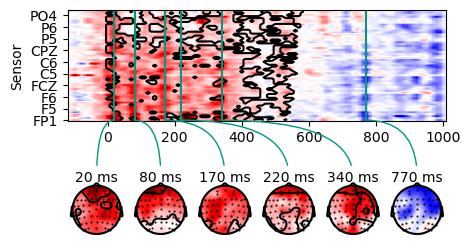

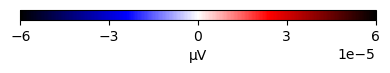

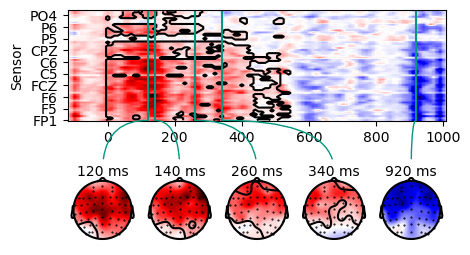

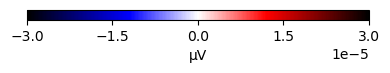

In [19]:
# Load the TRFs:
# Keep `h_scaled` instead of `h` so that we can compare and add TRFs to different predictors
# Because each predictor gets normalized for estimation, the scale of the TRFs in `h` are all different
# The `h_scaled` attribute reverses that normalization, so that the TRFs are all in a common scale

### FOR F0s (one sample so far)###
n_rows = []
for subject in ESL_SUBJECTS:
    n_subj = int(subject[5:8])
    n_trf = eelbrain.load.unpickle(TRF_DIR / subject[4:8] / f'{subject[4:8]} Fzero+envelope.pickle')
    print(n_trf.x)  # old: ['IMF_6', 'IMF_4', 'IMF_2', 'IMF_5', 'IMF_1', 'IMF_3']
    
    #n_trf.x = ['f0', 'f0env', 'f0envenvon'] #rename the model (no punctuation)
    n_rows.append([n_subj, model, *n_trf.h_scaled])
n_trfs = eelbrain.Dataset.from_caselist(['subject', 'model', *n_trf.x], n_rows)
print(n_trfs)


# redo the t-test (use one-sample to see effects from Ngram & CFG, because it is m1/m2 - m >>)
F0_Onesamtest = eelbrain.testnd.TTestOneSample('Fzero', match='subject', ds=n_trfs, tail=1, tstart=0, pmin=0.1)
F0_Env_Onesamtest = eelbrain.testnd.TTestOneSample('envelope', match='subject', ds=n_trfs, tail=1, tstart=0, pmin=0.1)
#F0_Env_EnvOn_Onesamtest = eelbrain.testnd.TTestOneSample('onset', match='subject', ds=n_trfs, tail=1, tstart=0, pmin=0.1)


#IMF_all_pairedttest = eelbrain.testnd.TTestRelated('imf1', 'imf12', 'imf123', 'imf1234', 'imf12345', 'imfAll', ds=n_trfs, tail=1, tstart=0, pmin=0.05)  #, match='subject'
# Tail >> set 0(two-tailed) or 1 (upper_one-tailed)?  ; Why we close the "subject", then it's ok >> match = None??

# Find the sig clusters
F0_Onesamtest_clus = F0_Onesamtest.find_clusters(0.05)
F0_Env_Onesamtest_clus = F0_Env_Onesamtest.find_clusters(0.05)
#F0_Env_EnvOn_Onesamtest_clus = F0_Env_EnvOn_Onesamtest.find_clusters(0.05)


#IMF_all_pairedttest_clus =IMF_all_pairedttest.find_clusters(0.05)

# Print out the Stats and its clusters
print(F0_Onesamtest)
print(F0_Onesamtest_clus)

print(F0_Env_Onesamtest)
print(F0_Env_Onesamtest_clus)
"""
print(F0_Env_EnvOn_Onesamtest)
print(F0_Env_EnvOn_Onesamtest_clus)
"""

# Plot the topoarray of model

p_F0 = eelbrain.plot.TopoArray(F0_Onesamtest, t=[0.02, 0.08, 0.17, 0.22, 0.34, 0.77], clip='circle') 
p_F0.plot_colorbar(width=0.1)

p_F0_Env = eelbrain.plot.TopoArray(F0_Env_Onesamtest, t=[0.12, 0.14, 0.26, 0.34, 0.92], clip='circle') 
p_F0_Env.plot_colorbar(width=0.1)
"""
p_F0_Env_EnvOn = eelbrain.plot.TopoArray(F0_Env_EnvOn_Onesamtest, t=[0.22, 0.27, 0.33, 0.41, 0.54], clip='circle') 
p_F0_Env_EnvOn.plot_colorbar(width=0.1)
"""

"""

p_F0.save(DST / 'ESLs_F0_TRF.png')
p_F0_Env.save(DST / 'ESLs_F0_Env_TRF.png')
p_F0_Env_EnvOn.save(DST / 'ESLs_F0_Env_EnvOn_TRF.png')
"""

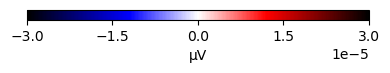

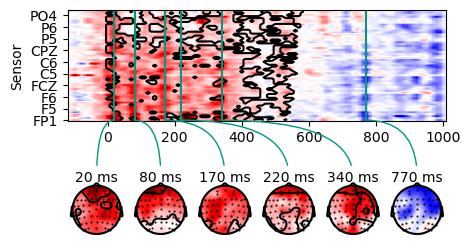

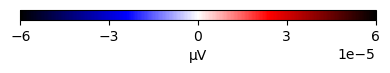

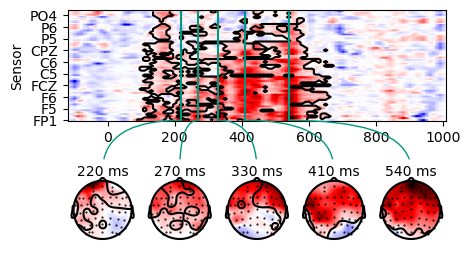

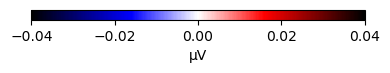

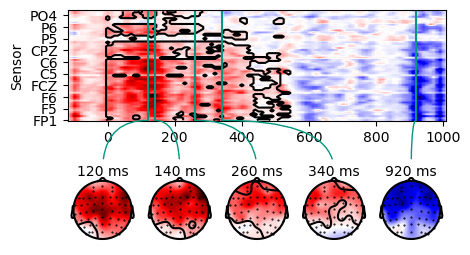

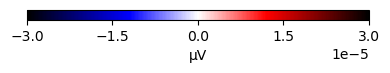

In [20]:
p_F0 = eelbrain.plot.TopoArray(F0_Onesamtest, t=[0.02, 0.08, 0.17, 0.22, 0.34, 0.77], clip='circle') 
p_F0.plot_colorbar(width=0.1)

p_F0_Env_EnvOn = eelbrain.plot.TopoArray(F0_Env_EnvOn_Onesamtest, t=[0.22, 0.27, 0.33, 0.41, 0.54], clip='circle') 
p_F0_Env_EnvOn.plot_colorbar(width=0.1)

p_F0_Env = eelbrain.plot.TopoArray(F0_Env_Onesamtest, t=[0.12, 0.14, 0.26, 0.34, 0.92], clip='circle') 
p_F0_Env.plot_colorbar(width=0.1)